<a href="https://colab.research.google.com/github/Lee-Gunju/GraphEmbedding-For-Soccer-Tactical-Formations/blob/main/football_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# wide & deep learning model 
# 3개의 아웃풋 (포메이션, 스타일, 승리 가능성) 


In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt


In [3]:
dataframe = pd.read_excel('Data.xlsx',  sheet_name = ['19-20', '18-19', '17-18', '16-17', '15-16', '14-15', '13-14', '12-13', '11-12', '10-11'])
concat_df = pd.concat(dataframe, axis= 0, ignore_index=True)

In [4]:
concat_df.head(1)

,match_oder,oppense_team,FW0,FW0B,FW1,AMF0,AMF0B,AMF1,AMF1B,Wing0,Wing0B,Wing1,Wing1B,CMF0,CMF0B,CMF0C,CMF1,CMF1B,DMF0,DMF1,DMF1B,WB0,WB0B,WB1,WB1B,CB0,CB0B,CB1,CB1B,GK0,GK1,Formation,Opp_Level,Season,Ball_pos,Win,Style,sum
0,1 round,Aston Villa,1,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,1,0,0,1,1,0,0,1,0,4-1-2-1-2,Low,2019-2020,70.1,Win,0,11


데이터 변수 - 
match_order = 범위값
oppense_team = 범위값 
Position = 숫자(0, 1)
Opp_Level = 범위 
Season = 범위 
Ball_pos = 숫자 (연속?)

라벨 -
Formation = 라벨(범위) 
Win = 범위 (승무패)
Style = 범위 (0, 1)

In [5]:
label_formation = concat_df['Formation'].unique().tolist()
season = concat_df['Season'].unique().tolist()
opp_level = concat_df['Opp_Level'].unique().tolist()
oppense_team = concat_df['oppense_team'].unique().tolist()
match_order = concat_df['match_oder'].unique().tolist()
win_cate = concat_df['Win'].unique().tolist()


In [6]:
formation_to_encoded = {x: i for i, x in enumerate(label_formation)}
index_to_formation = {i: x for i, x in enumerate(label_formation)}

season_to_encoded = {x: i for i, x in enumerate(season)}
index_to_season = {i: x for i, x in enumerate(season)} 

opp_level_to_encoded = {x: i for i, x in enumerate(opp_level)}
index_to_opp_level = {i: x for i, x in enumerate(opp_level)} 

oppense_team_to_encoded = {x: i for i, x in enumerate(oppense_team)}
index_to_oppense_team = {i: x for i, x in enumerate(oppense_team)} 

match_order_to_encoded = {x: i for i, x in enumerate(match_order)}
index_to_match_order = {i: x for i, x in enumerate(match_order)} 

win_to_encoded = {x: i for i, x in enumerate(win_cate)}
index_to_win = {i: x for i, x in enumerate(win_cate)} 

In [7]:
concat_df['label'] = concat_df['Formation'].map(formation_to_encoded)
concat_df['Match_order'] = concat_df['match_oder'].map(match_order_to_encoded)
concat_df['Oppense_team'] = concat_df['oppense_team'].map(oppense_team_to_encoded)
concat_df['Oppense_level'] = concat_df['Opp_Level'].map(opp_level_to_encoded)
concat_df['season'] = concat_df['Season'].map(season_to_encoded)

concat_df['win_index'] = concat_df['Win'].map(win_to_encoded)

In [8]:
min_match_order = min(concat_df["Match_order"])
max_match_order = max(concat_df["Match_order"])

min_oppense_team = min(concat_df["Oppense_team"])
max_oppense_team = max(concat_df["Oppense_team"])


min_oppense_level = min(concat_df["Oppense_level"])
max_oppense_level = max(concat_df["Oppense_level"])

min_season = min(concat_df["season"])
max_season = max(concat_df["season"])

min_ball_pos = min(concat_df['Ball_pos'])
max_ball_pos = max(concat_df['Ball_pos'])

In [9]:
concat_df['reg_match_order'] = concat_df["Match_order"].apply(lambda x: (x - min_match_order) / (max_match_order - min_match_order)).values
concat_df['reg_oppense_team'] = concat_df["Oppense_team"].apply(lambda x: (x - min_oppense_team) / (max_oppense_team - min_oppense_team)).values
concat_df['reg_oppense_level'] = concat_df["Oppense_level"].apply(lambda x: (x - min_oppense_level) / (max_oppense_level - min_oppense_level)).values
concat_df['reg_season'] = concat_df["season"].apply(lambda x: (x - min_season) / (max_season - min_season)).values
concat_df['reg_ball_pos'] = concat_df["Ball_pos"].apply(lambda x: (x - min_ball_pos) / (max_ball_pos - min_ball_pos)).values

In [119]:
df = concat_df.sample(frac=1, random_state=42)

In [120]:
df.head(1)

,match_oder,oppense_team,FW0,FW0B,FW1,AMF0,AMF0B,AMF1,AMF1B,Wing0,Wing0B,Wing1,Wing1B,CMF0,CMF0B,CMF0C,CMF1,CMF1B,DMF0,DMF1,DMF1B,WB0,WB0B,WB1,WB1B,CB0,CB0B,CB1,CB1B,GK0,GK1,Formation,Opp_Level,Season,Ball_pos,Win,Style,sum,label,Match_order,Oppense_team,Oppense_level,season,win_index,reg_match_order,reg_oppense_team,reg_oppense_level,reg_season,reg_ball_pos
266,1 round,New castle,1,0,0,1,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,1,0,4-0-2-1-3,Low,2012-2013,48.1,Lose,1,11,5,0,2,0,7,2,0.0,0.058824,0.0,0.777778,0.40884


In [121]:
# feature의 값을 정규화 적용
x = df[["FW0", "FW0B", "FW1" ,'AMF0', 'AMF0B', 'AMF1', 'AMF1B',
       'Wing0', 'Wing0B', 'Wing1', 'Wing1B', 'CMF0', 'CMF0B', 'CMF0C', 'CMF1',
       'CMF1B', 'DMF0', 'DMF1', 'DMF1B', 'WB0', 'WB0B', 'WB1', 'WB1B', 'CB0',
       'CB0B', 'CB1', 'CB1B', 'GK0', 'GK1', 'reg_oppense_team', 'reg_oppense_level','reg_season','reg_ball_pos']].values.astype(np.float)



y_formation = df["label"].values.astype(np.float)
y_win_rating = df['win_index'].values.astype(np.float)
y_style = df['Style'].values.astype(np.float)

In [122]:
train_indices = int(0.9 * df.shape[0])

In [123]:
x_train, x_val, y_train_formation, y_val_formation, y_train_win_rating, y_val_win_rating, y_train_style, y_val_style = (
    x[:train_indices],
    x[train_indices:],
    y_formation[:train_indices],
    y_formation[train_indices:],
    y_win_rating[:train_indices],
    y_win_rating[train_indices:],
    y_style[:train_indices],
    y_style[train_indices:],

)

In [124]:
# 데이터를 나눈다.
x_train_A, x_train_B = x_train[:, :32], x_train[:, 32:]
x_val_A, x_val_B = x_val[:, :32], x_val[:, 32:]

In [125]:
print(x_train_A.shape, x_train_B.shape)

(342, 32) (342, 1)


In [126]:
learning_rate = 0.01
dropout_rate = 0.1

In [111]:
def wide_deep_model():
  input_A = layers.Input(shape = (x_train_A.shape[1]), name = 'wide_input')
  input_B = layers.Input(shape = (x_train_B.shape[1]), name = 'deep_input')

  x = layers.Dense(64, activation='relu')(input_B)
  x = layers.Dense(64, activation='relu')(x)

  concat = layers.concatenate([input_A, x], name = 'concat')

  x_1 = layers.Dense(42, kernel_regularizer=keras.regularizers.l2(0.001))(concat)
  x_1 = layers.BatchNormalization()(x_1)
  x_1 = layers.ReLU()(x_1)
  x_1 = layers.Dropout(dropout_rate)(x_1)
  output_for = layers.Dense(31, activation='softmax', name='output_for')(x_1)

  x_2 = layers.Dense(42, kernel_regularizer=keras.regularizers.l2(0.001))(concat)
  x_2 = layers.BatchNormalization()(x_2)
  x_2 = layers.ReLU()(x_2)
  x_2 = layers.Dropout(dropout_rate)(x_2)
  output_style = layers.Dense(2, activation='softmax', name='output_style')(x_2)

  x_3 = layers.Dense(42, kernel_regularizer=keras.regularizers.l2(0.001))(concat)
  x_3 = layers.BatchNormalization()(x_3)
  x_3 = layers.ReLU()(x_3)
  x_3 = layers.Dropout(dropout_rate)(x_3)
  x_3 = layers.Dense(24, kernel_regularizer=keras.regularizers.l2(0.001))(x_3)
  x_3 = layers.BatchNormalization()(x_3)
  x_3 = layers.ReLU()(x_3)
  x_3 = layers.Dropout(dropout_rate)(x_3)
  x_3 = layers.Dense(12)(x_3)
  x_3 = layers.BatchNormalization()(x_3)
  x_3 = layers.ReLU()(x_3)
  x_3 = layers.Dropout(dropout_rate)(x_3)
  output_win = layers.Dense(3, activation='softmax', name='output_win')(x_3)



  model = keras.Model(inputs = [input_A, input_B], outputs = [output_for, output_style, output_win],  name = 'multi_model')

  return model 

In [112]:
model = wide_deep_model()

In [113]:
class MulticlassTruePositives(tf.keras.metrics.Metric):
    def __init__(self, name='multiclass_true_positives', **kwargs):
        super(MulticlassTruePositives, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.reshape(tf.argmax(y_pred, axis=1), shape=(-1, 1))
        values = tf.cast(y_true, 'int32') == tf.cast(y_pred, 'int32')
        values = tf.cast(values, 'float32')
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, 'float32')
            values = tf.multiply(values, sample_weight)
        self.true_positives.assign_add(tf.reduce_sum(values))

    def result(self):
        return self.true_positives

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.true_positives.assign(0.)

In [131]:
from keras import backend as K

def recall(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    recall = true_positives / (all_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [136]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
              loss= {'output_for': keras.losses.SparseCategoricalCrossentropy(), 
                      'output_win':keras.losses.SparseCategoricalCrossentropy(), 
                      'output_style':keras.losses.SparseCategoricalCrossentropy()},
              metrics =  {'output_for': [keras.metrics.SparseCategoricalAccuracy(), recall, precision],
                      'output_win':[keras.metrics.SparseCategoricalAccuracy(),recall, precision], 
                      'output_style':[keras.metrics.SparseCategoricalAccuracy(), recall, precision] }
              
              # {'output_for': [keras.losses.SparseCategoricalCrossentropy() ,keras.metrics.Precision(name='precision'),keras.metrics.Recall(name='recall')],
              #         'output_win':[keras.losses.SparseCategoricalCrossentropy(),keras.metrics.Precision(name='precision'),keras.metrics.Recall(name='recall')], 
              #         'output_style':[keras.losses.SparseCategoricalCrossentropy() ,keras.metrics.Precision(name='precision'),keras.metrics.Recall(name='recall')]}
)

In [137]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience= 10, restore_best_weights=True)

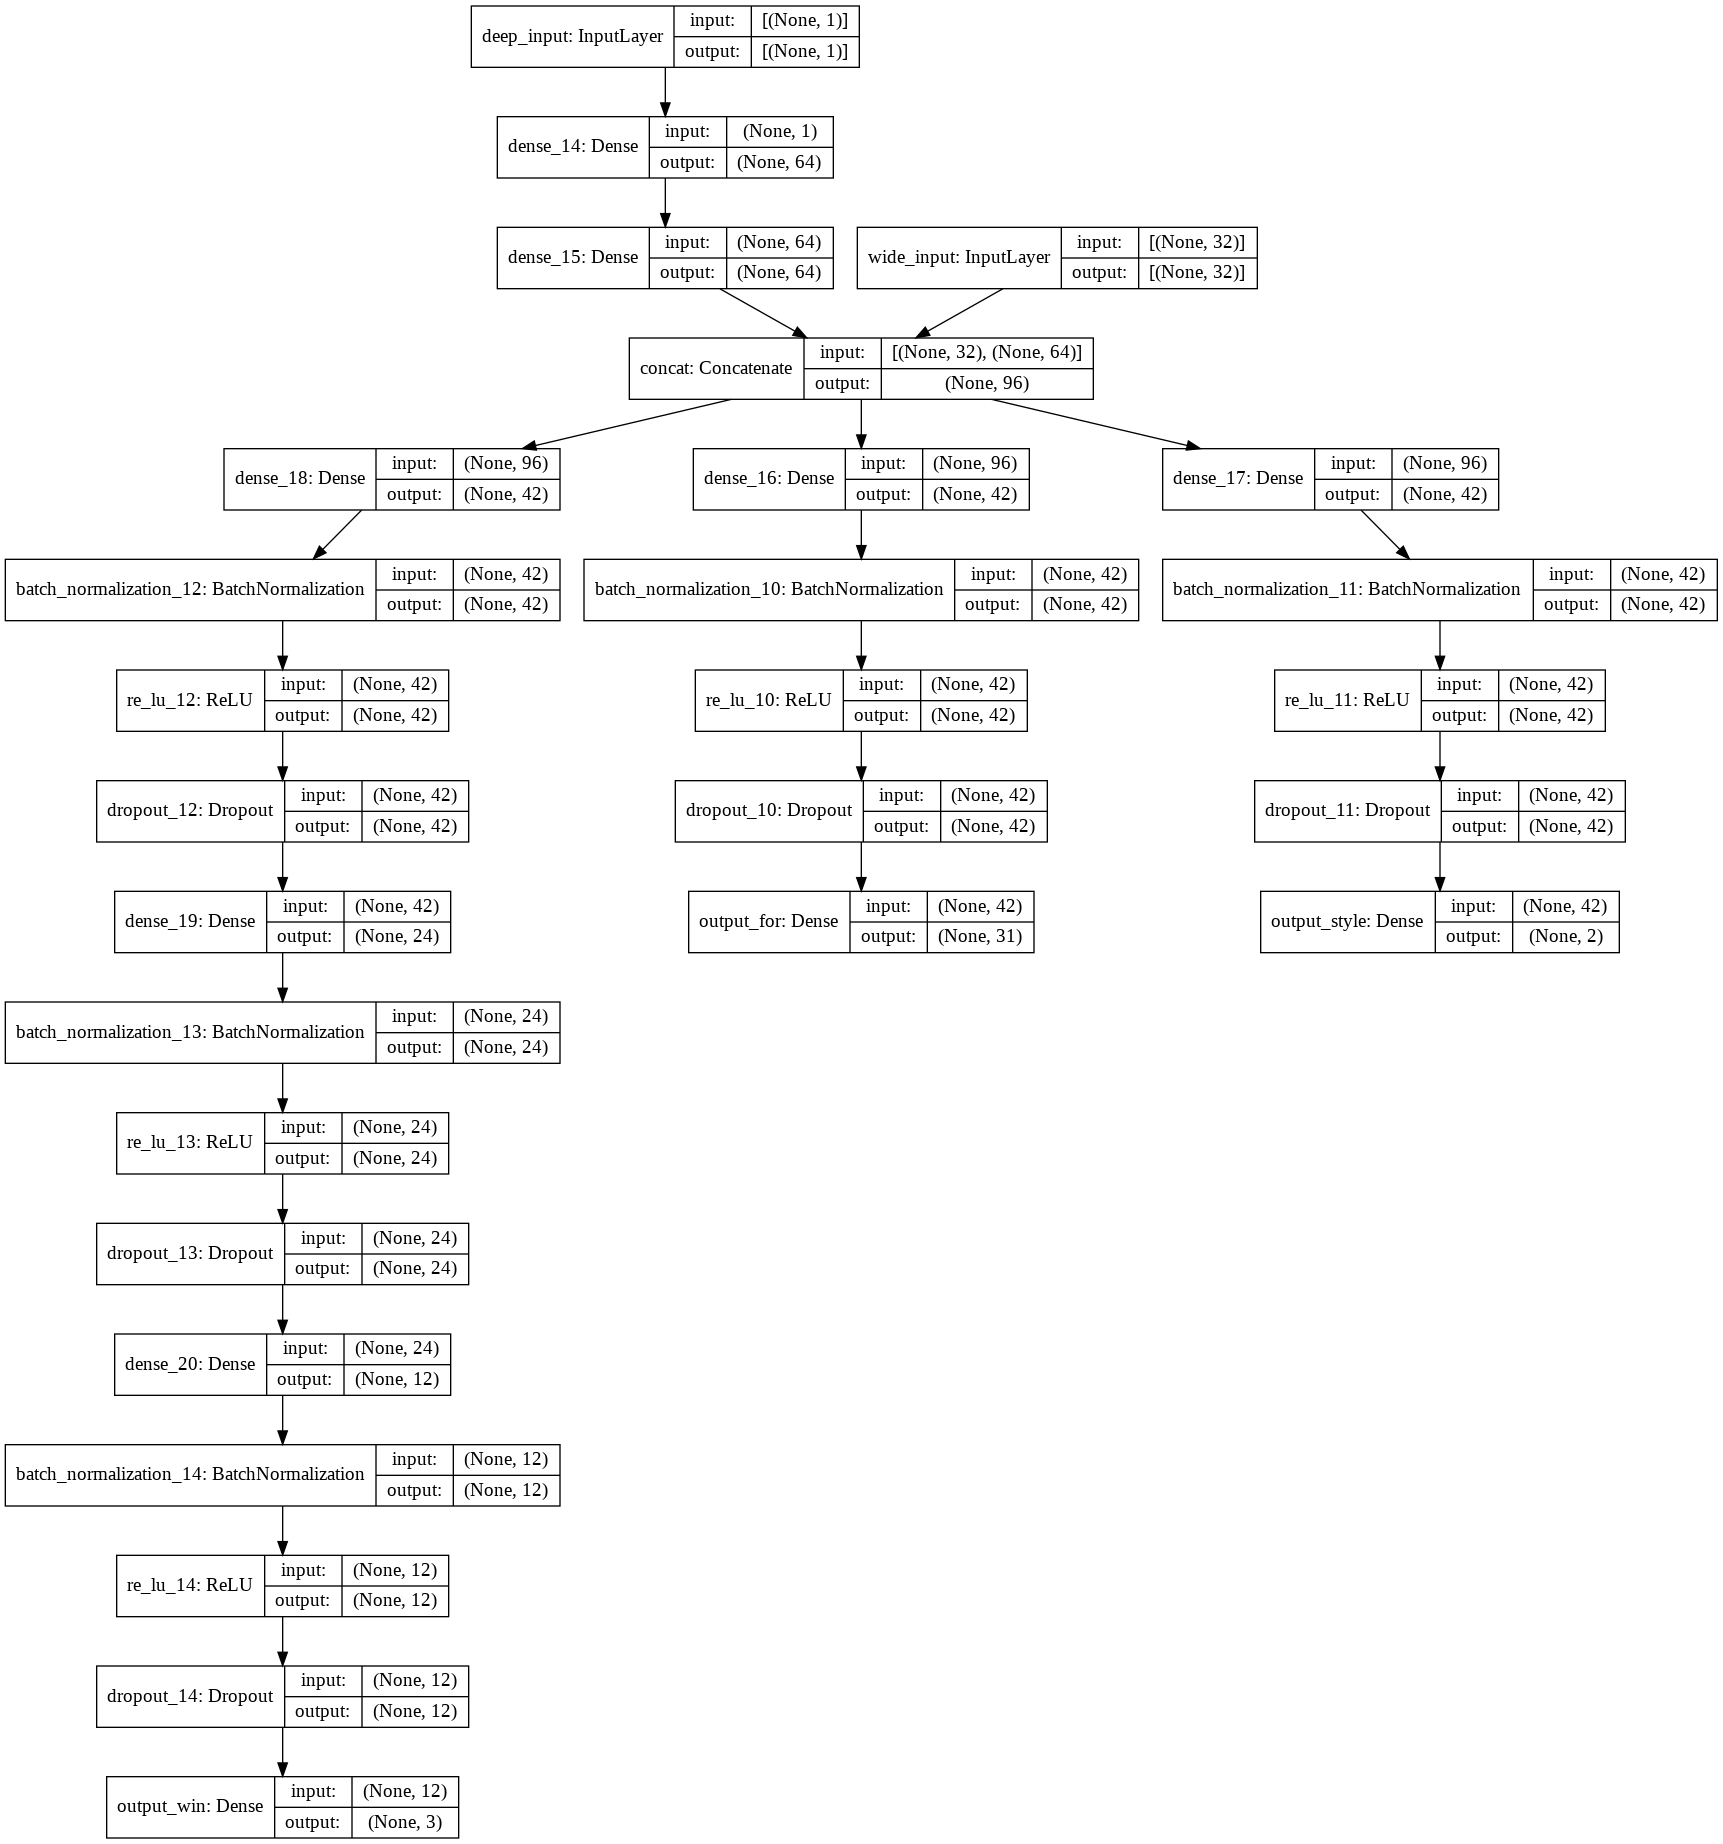

In [138]:
keras.utils.plot_model(model, show_shapes=True)

In [139]:
history = model.fit(x=[x_train_A, x_train_B], y = [y_train_formation, y_train_style,y_train_win_rating], epochs=100, validation_split=0.2 , callbacks=[early_stop])

Epoch 1/100
9/9 [==============================] - 3s 85ms/step - loss: 1.2806 - output_for_loss: 0.1074 - output_style_loss: 0.1861 - output_win_loss: 0.8655 - output_for_sparse_categorical_accuracy: 0.9744 - output_for_recall: 0.9792 - output_for_precision: 1.0000 - output_style_sparse_categorical_accuracy: 0.9341 - output_style_recall: 1.0000 - output_style_precision: 1.0000 - output_win_sparse_categorical_accuracy: 0.5824 - output_win_recall: 0.7316 - output_win_precision: 1.0000 - val_loss: 2.8388 - val_output_for_loss: 0.7854 - val_output_style_loss: 0.5795 - val_output_win_loss: 1.3525 - val_output_for_sparse_categorical_accuracy: 0.8261 - val_output_for_recall: 0.8604 - val_output_for_precision: 1.0000 - val_output_style_sparse_categorical_accuracy: 0.7971 - val_output_style_recall: 1.0000 - val_output_style_precision: 1.0000 - val_output_win_sparse_categorical_accuracy: 0.5507 - val_output_win_recall: 0.7417 - val_output_win_precision: 1.0000
Epoch 2/100
9/9 [=================

In [140]:
model.evaluate(x=[x_val_A, x_val_B], y = [y_val_formation, y_val_style, y_val_win_rating])

# L2 정규화를 dense layer에 추가하니 살짝, 안정적으로 학습 진행됨! 

2/2 [==============================] - 0s 12ms/step - loss: 2.7886 - output_for_loss: 1.2763 - output_style_loss: 0.3724 - output_win_loss: 1.0165 - output_for_sparse_categorical_accuracy: 0.8947 - output_for_recall: 0.8542 - output_for_precision: 1.0000 - output_style_sparse_categorical_accuracy: 0.8421 - output_style_recall: 1.0000 - output_style_precision: 1.0000 - output_win_sparse_categorical_accuracy: 0.5263 - output_win_recall: 0.6510 - output_win_precision: 1.0000


[2.788586139678955,
 1.2763392925262451,
 0.3724040687084198,
 1.0164583921432495,
 0.8947368264198303,
 0.8541666269302368,
 1.0,
 0.8421052694320679,
 1.0,
 1.0,
 0.5263158082962036,
 0.6510416269302368,
 1.0]

In [141]:
history.history.keys()

dict_keys(['loss', 'output_for_loss', 'output_style_loss', 'output_win_loss', 'output_for_sparse_categorical_accuracy', 'output_for_recall', 'output_for_precision', 'output_style_sparse_categorical_accuracy', 'output_style_recall', 'output_style_precision', 'output_win_sparse_categorical_accuracy', 'output_win_recall', 'output_win_precision', 'val_loss', 'val_output_for_loss', 'val_output_style_loss', 'val_output_win_loss', 'val_output_for_sparse_categorical_accuracy', 'val_output_for_recall', 'val_output_for_precision', 'val_output_style_sparse_categorical_accuracy', 'val_output_style_recall', 'val_output_style_precision', 'val_output_win_sparse_categorical_accuracy', 'val_output_win_recall', 'val_output_win_precision'])

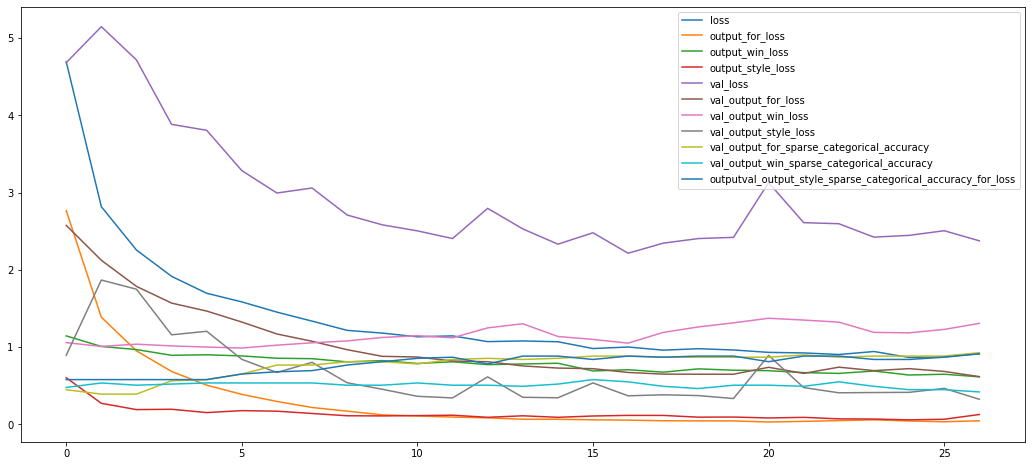

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize = (18,8))

plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['output_for_loss'], label = 'output_for_loss')
plt.plot(history.history['output_win_loss'] ,label = 'output_win_loss')
plt.plot(history.history['output_style_loss'],label = 'output_style_loss')

# plt.plot(history.history['output_for_sparse_categorical_accuracy'],label = 'output_for_sparse_categorical_accuracy')
# plt.plot(history.history['output_win_sparse_categorical_accuracy'],label = 'output_win_sparse_categorical_accuracy')
# plt.plot(history.history['output_style_sparse_categorical_accuracy'],label = 'output_style_sparse_categorical_accuracy')

plt.plot(history.history['val_loss'],label = 'val_loss')
plt.plot(history.history['val_output_for_loss'],label = 'val_output_for_loss')
plt.plot(history.history['val_output_win_loss'],label = 'val_output_win_loss')
plt.plot(history.history['val_output_style_loss'],label = 'val_output_style_loss')

plt.plot(history.history['val_output_for_sparse_categorical_accuracy'],label = 'val_output_for_sparse_categorical_accuracy')
plt.plot(history.history['val_output_win_sparse_categorical_accuracy'],label = 'val_output_win_sparse_categorical_accuracy')
plt.plot(history.history['val_output_style_sparse_categorical_accuracy'],label = 'outputval_output_style_sparse_categorical_accuracy_for_loss')

plt.legend(loc = 'upper right')
         

In [ ]:
def wide_deep_model_with_sigmoid():
  input_A = layers.Input(shape = (x_train_A.shape[1]), name = 'wide_input')
  input_B = layers.Input(shape = (x_train_B.shape[1]), name = 'deep_input')

  x = layers.Dense(64, activation='relu')(input_B)
  x = layers.Dense(64, activation='relu')(x)

  concat = layers.concatenate([input_A, x], name = 'concat')

  x_1 = layers.Dense(42)(concat)
  x_1 = layers.BatchNormalization()(x_1)
  x_1 = layers.ReLU()(x_1)
  x_1 = layers.Dropout(dropout_rate)(x_1)
  output_for = layers.Dense(31, activation='softmax', name='output_for')(x_1)

  x_2 = layers.Dense(42)(concat)
  x_2 = layers.BatchNormalization()(x_2)
  x_2 = layers.ReLU()(x_2)
  x_2 = layers.Dropout(dropout_rate)(x_2)
  output_style = layers.Dense(2, activation='softmax', name='output_style')(x_2)

  x_3 = layers.Dense(42)(concat)
  x_3 = layers.BatchNormalization()(x_3)
  x_3 = layers.ReLU()(x_3)
  x_3 = layers.Dropout(dropout_rate)(x_3)
  x_3 = layers.Dense(24)(x_3)
  x_3 = layers.BatchNormalization()(x_3)
  x_3 = layers.ReLU()(x_3)
  x_3 = layers.Dropout(dropout_rate)(x_3)
  x_3 = layers.Dense(12)(x_3)
  x_3 = layers.BatchNormalization()(x_3)
  x_3 = layers.ReLU()(x_3)
  x_3 = layers.Dropout(dropout_rate)(x_3)
  output_win = layers.Dense(3, activation='sigmoid', name='output_win')(x_3)



  model = keras.Model(inputs = [input_A, input_B], outputs = [output_for, output_style, output_win],  name = 'multi_model')

  return model 

In [ ]:
model = wide_deep_model_with_sigmoid()
model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9), 
              
              loss= {'output_for': keras.losses.SparseCategoricalCrossentropy(),  
                      'output_style':keras.losses.SparseCategoricalCrossentropy(),
                     'output_win':keras.losses.CategoricalCrossentropy()},
              
              metrics ={'output_for': keras.metrics.SparseCategoricalAccuracy(),  
                      'output_style':keras.metrics.SparseCategoricalAccuracy(),
                      'output_win':keras.metrics.CategoricalAccuracy()}
              )

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience= 10, restore_best_weights=True)

In [ ]:
history = model.fit(x=[x_train_A, x_train_B], y = [y_train_formation, y_train_style, tf.keras.utils.to_categorical(y_train_win_rating, 3)], epochs=100, batch_size = 24, validation_split=0.2 , callbacks=[early_stop])

Epoch 1/100
12/12 [==============================] - 2s 44ms/step - loss: 5.3877 - output_for_loss: 3.2507 - output_style_loss: 0.7945 - output_win_loss: 1.3425 - output_for_sparse_categorical_accuracy: 0.1941 - output_style_sparse_categorical_accuracy: 0.5201 - output_win_categorical_accuracy: 0.3480 - val_loss: 4.6442 - val_output_for_loss: 2.8504 - val_output_style_loss: 0.6961 - val_output_win_loss: 1.0978 - val_output_for_sparse_categorical_accuracy: 0.3768 - val_output_style_sparse_categorical_accuracy: 0.5362 - val_output_win_categorical_accuracy: 0.3623
Epoch 2/100
12/12 [==============================] - 0s 11ms/step - loss: 3.7867 - output_for_loss: 2.1482 - output_style_loss: 0.5992 - output_win_loss: 1.0393 - output_for_sparse_categorical_accuracy: 0.5018 - output_style_sparse_categorical_accuracy: 0.6996 - output_win_categorical_accuracy: 0.5018 - val_loss: 4.1185 - val_output_for_loss: 2.4172 - val_output_style_loss: 0.6701 - val_output_win_loss: 1.0313 - val_output_for_s

In [ ]:
model.evaluate(x=[x_val_A, x_val_B], y = [y_val_formation, y_val_style, tf.keras.utils.to_categorical(y_val_win_rating, 3)])

# win_output의 activation func을 sigmoid로 바꿔도 별 차이 없다..... 승패 예측은 별 차이없음!!! 
# optimizer를 SGD도 Adam과 큰 차이가 없다.
# 

2/2 [==============================] - 0s 9ms/step - loss: 2.4102 - output_for_loss: 1.0666 - output_style_loss: 0.3307 - output_win_loss: 1.0129 - output_for_sparse_categorical_accuracy: 0.8421 - output_style_sparse_categorical_accuracy: 0.8421 - output_win_categorical_accuracy: 0.5000


[2.410229444503784,
 1.0666239261627197,
 0.3306812644004822,
 1.012924313545227,
 0.8421052694320679,
 0.8421052694320679,
 0.5]

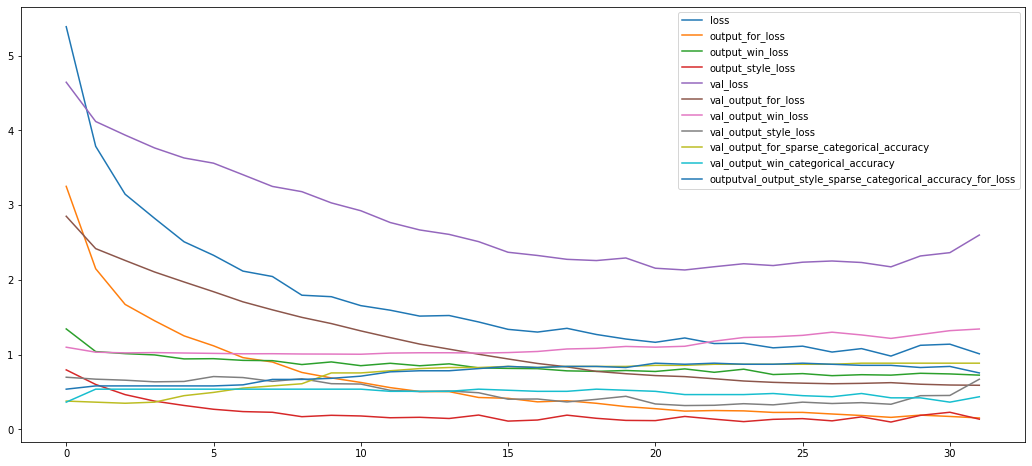

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (18,8))

plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['output_for_loss'], label = 'output_for_loss')
plt.plot(history.history['output_win_loss'] ,label = 'output_win_loss')
plt.plot(history.history['output_style_loss'],label = 'output_style_loss')

# plt.plot(history.history['output_for_sparse_categorical_accuracy'],label = 'output_for_sparse_categorical_accuracy')
# plt.plot(history.history['output_win_sparse_categorical_accuracy'],label = 'output_win_sparse_categorical_accuracy')
# plt.plot(history.history['output_style_sparse_categorical_accuracy'],label = 'output_style_sparse_categorical_accuracy')

plt.plot(history.history['val_loss'],label = 'val_loss')
plt.plot(history.history['val_output_for_loss'],label = 'val_output_for_loss')
plt.plot(history.history['val_output_win_loss'],label = 'val_output_win_loss')
plt.plot(history.history['val_output_style_loss'],label = 'val_output_style_loss')

plt.plot(history.history['val_output_for_sparse_categorical_accuracy'],label = 'val_output_for_sparse_categorical_accuracy')
plt.plot(history.history['val_output_win_categorical_accuracy'],label = 'val_output_win_categorical_accuracy')
plt.plot(history.history['val_output_style_sparse_categorical_accuracy'],label = 'outputval_output_style_sparse_categorical_accuracy_for_loss')

plt.legend(loc = 'upper right')

In [ ]:
'''
1. baseline - wide and deep X(그냥 단순한 모델) + 데이터 가공
2. wide and deep model + without 데이터 가공 (클러스터링 + 피쳐 엔지니어링 하지 않은 데이터)  
3. wide and deep model + 데이터 가공
'''


In [206]:
# 데이터 전처리! 
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt


In [207]:
dataframe = pd.read_excel('Data.xlsx',  sheet_name = ['20-21-test','19-20', '18-19', '17-18', '16-17', '15-16', '14-15', '13-14', '12-13', '11-12', '10-11'])
concat_df = pd.concat(dataframe, axis= 0, ignore_index=True)

In [208]:
concat_df.head(1)

,match_oder,oppense_team,FW0,FW0B,FW1,AMF0,AMF0B,AMF1,AMF1B,Wing0,Wing0B,Wing1,Wing1B,CMF0,CMF0B,CMF0C,CMF1,CMF1B,DMF0,DMF1,DMF1B,WB0,WB0B,WB1,WB1B,CB0,CB0B,CB1,CB1B,GK0,GK1,Formation,Opp_Level,Season,Ball_pos,Win,Style,sum
0,1 round,Everton,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,1,0,1,0,1,1,0,0,1,0,4-2-0-1-3,Mid,2020-2021,51.6,Lose,1,11


In [209]:
len(concat_df)

418

In [210]:
label_formation = concat_df['Formation'].unique().tolist()
season = concat_df['Season'].unique().tolist()
opp_level = concat_df['Opp_Level'].unique().tolist()
oppense_team = concat_df['oppense_team'].unique().tolist()
match_order = concat_df['match_oder'].unique().tolist()
win_cate = concat_df['Win'].unique().tolist()


In [211]:
formation_to_encoded = {x: i for i, x in enumerate(label_formation)}
index_to_formation = {i: x for i, x in enumerate(label_formation)}

season_to_encoded = {x: i for i, x in enumerate(season)}
index_to_season = {i: x for i, x in enumerate(season)} 

opp_level_to_encoded = {x: i for i, x in enumerate(opp_level)}
index_to_opp_level = {i: x for i, x in enumerate(opp_level)} 

oppense_team_to_encoded = {x: i for i, x in enumerate(oppense_team)}
index_to_oppense_team = {i: x for i, x in enumerate(oppense_team)} 

match_order_to_encoded = {x: i for i, x in enumerate(match_order)}
index_to_match_order = {i: x for i, x in enumerate(match_order)} 

win_to_encoded = {x: i for i, x in enumerate(win_cate)}
index_to_win = {i: x for i, x in enumerate(win_cate)} 

In [212]:
concat_df['label'] = concat_df['Formation'].map(formation_to_encoded)
concat_df['Match_order'] = concat_df['match_oder'].map(match_order_to_encoded)
concat_df['Oppense_team'] = concat_df['oppense_team'].map(oppense_team_to_encoded)
concat_df['Oppense_level'] = concat_df['Opp_Level'].map(opp_level_to_encoded)
concat_df['season'] = concat_df['Season'].map(season_to_encoded)

concat_df['win_index'] = concat_df['Win'].map(win_to_encoded)

In [213]:
min_match_order = min(concat_df["Match_order"])
max_match_order = max(concat_df["Match_order"])

min_oppense_team = min(concat_df["Oppense_team"])
max_oppense_team = max(concat_df["Oppense_team"])


min_oppense_level = min(concat_df["Oppense_level"])
max_oppense_level = max(concat_df["Oppense_level"])

min_season = min(concat_df["season"])
max_season = max(concat_df["season"])

min_ball_pos = min(concat_df['Ball_pos'])
max_ball_pos = max(concat_df['Ball_pos'])

In [214]:
concat_df['reg_match_order'] = concat_df["Match_order"].apply(lambda x: (x - min_match_order) / (max_match_order - min_match_order)).values
concat_df['reg_oppense_team'] = concat_df["Oppense_team"].apply(lambda x: (x - min_oppense_team) / (max_oppense_team - min_oppense_team)).values
concat_df['reg_oppense_level'] = concat_df["Oppense_level"].apply(lambda x: (x - min_oppense_level) / (max_oppense_level - min_oppense_level)).values
concat_df['reg_season'] = concat_df["season"].apply(lambda x: (x - min_season) / (max_season - min_season)).values
concat_df['reg_ball_pos'] = concat_df["Ball_pos"].apply(lambda x: (x - min_ball_pos) / (max_ball_pos - min_ball_pos)).values

In [246]:
df = concat_df.sample(frac=1, random_state=42)

In [247]:
df.head(1)

,match_oder,oppense_team,FW0,FW0B,FW1,AMF0,AMF0B,AMF1,AMF1B,Wing0,Wing0B,Wing1,Wing1B,CMF0,CMF0B,CMF0C,CMF1,CMF1B,DMF0,DMF1,DMF1B,WB0,WB0B,WB1,WB1B,CB0,CB0B,CB1,CB1B,GK0,GK1,Formation,Opp_Level,Season,Ball_pos,Win,Style,sum,label,Match_order,Oppense_team,Oppense_level,season,win_index,reg_match_order,reg_oppense_team,reg_oppense_level,reg_season,reg_ball_pos
321,18 round,Stoke City,1,1,0,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,1,0,1,0,1,0,1,0,4-0-3-1-2,Mid,2012-2013,63.2,Draw,0,11,26,17,25,0,8,2,0.459459,0.714286,0.0,0.8,0.696429


In [248]:
# 20-21 시즌 
test_data = df[df['Season'] == '2020-2021']

In [249]:
# 10-11 ~ 19-20 시즌 
train_data = df[df['Season'] != '2020-2021']

In [250]:
# feature의 값을 정규화 적용
x_train = train_data[["FW0", "FW0B", "FW1" ,'AMF0', 'AMF0B', 'AMF1', 'AMF1B',
       'Wing0', 'Wing0B', 'Wing1', 'Wing1B', 'CMF0', 'CMF0B', 'CMF0C', 'CMF1',
       'CMF1B', 'DMF0', 'DMF1', 'DMF1B', 'WB0', 'WB0B', 'WB1', 'WB1B', 'CB0',
       'CB0B', 'CB1', 'CB1B', 'GK0', 'GK1', 'reg_oppense_team', 'reg_oppense_level','reg_season','reg_ball_pos']].values.astype(np.float)



y_train_formation = train_data["label"].values.astype(np.int)
y_train_win_rating = train_data['win_index'].values.astype(np.int)
y_train_style = train_data['Style'].values.astype(np.int)

In [251]:
# feature의 값을 정규화 적용
x_test = test_data[["FW0", "FW0B", "FW1" ,'AMF0', 'AMF0B', 'AMF1', 'AMF1B',
       'Wing0', 'Wing0B', 'Wing1', 'Wing1B', 'CMF0', 'CMF0B', 'CMF0C', 'CMF1',
       'CMF1B', 'DMF0', 'DMF1', 'DMF1B', 'WB0', 'WB0B', 'WB1', 'WB1B', 'CB0',
       'CB0B', 'CB1', 'CB1B', 'GK0', 'GK1', 'reg_oppense_team', 'reg_oppense_level','reg_season','reg_ball_pos']].values.astype(np.float)



y_test_formation = test_data["label"].values.astype(np.int)
y_test_win_rating = test_data['win_index'].values.astype(np.int)
y_test_style = test_data['Style'].values.astype(np.int)

In [252]:
# 인풋 데이터의 형태에 따라 데이터를 나눈다.
x_train_A, x_train_B = x_train[:, :32], x_train[:, 32:]
x_test_A, x_test_B = x_test[:, :32], x_test[:, 32:]

In [253]:
print(x_train_A.shape, x_train_B.shape)
print(x_test_A.shape, x_test_B.shape)

(380, 32) (380, 1)
(38, 32) (38, 1)


# Wide and deep model - our model




In [254]:
learning_rate = 0.01
dropout_rate = 0.1

In [255]:
def wide_deep_model():
  input_A = layers.Input(shape = (x_train_A.shape[1]), name = 'wide_input')
  input_B = layers.Input(shape = (x_train_B.shape[1]), name = 'deep_input')

  x = layers.Dense(64, activation='relu')(input_B)
  x = layers.Dense(64, activation='relu')(x)

  concat = layers.concatenate([input_A, x], name = 'concat')

  x_1 = layers.Dense(42, kernel_regularizer=keras.regularizers.l2(0.001))(concat)
  x_1 = layers.BatchNormalization()(x_1)
  x_1 = layers.ReLU()(x_1)
  x_1 = layers.Dropout(dropout_rate)(x_1)
  output_for = layers.Dense(31, activation='softmax', name='output_for')(x_1)

  x_2 = layers.Dense(42, kernel_regularizer=keras.regularizers.l2(0.001))(concat)
  x_2 = layers.BatchNormalization()(x_2)
  x_2 = layers.ReLU()(x_2)
  x_2 = layers.Dropout(dropout_rate)(x_2)
  output_style = layers.Dense(2, activation='softmax', name='output_style')(x_2)

  x_3 = layers.Dense(42, kernel_regularizer=keras.regularizers.l2(0.001))(concat)
  x_3 = layers.BatchNormalization()(x_3)
  x_3 = layers.ReLU()(x_3)
  x_3 = layers.Dropout(dropout_rate)(x_3)
  x_3 = layers.Dense(24, kernel_regularizer=keras.regularizers.l2(0.001))(x_3)
  x_3 = layers.BatchNormalization()(x_3)
  x_3 = layers.ReLU()(x_3)
  x_3 = layers.Dropout(dropout_rate)(x_3)
  x_3 = layers.Dense(12)(x_3)
  x_3 = layers.BatchNormalization()(x_3)
  x_3 = layers.ReLU()(x_3)
  x_3 = layers.Dropout(dropout_rate)(x_3)
  output_win = layers.Dense(3, activation='softmax', name='output_win')(x_3)



  model = keras.Model(inputs = [input_A, input_B], outputs = [output_for, output_style, output_win],  name = 'multi_model')

  return model 


model = wide_deep_model()

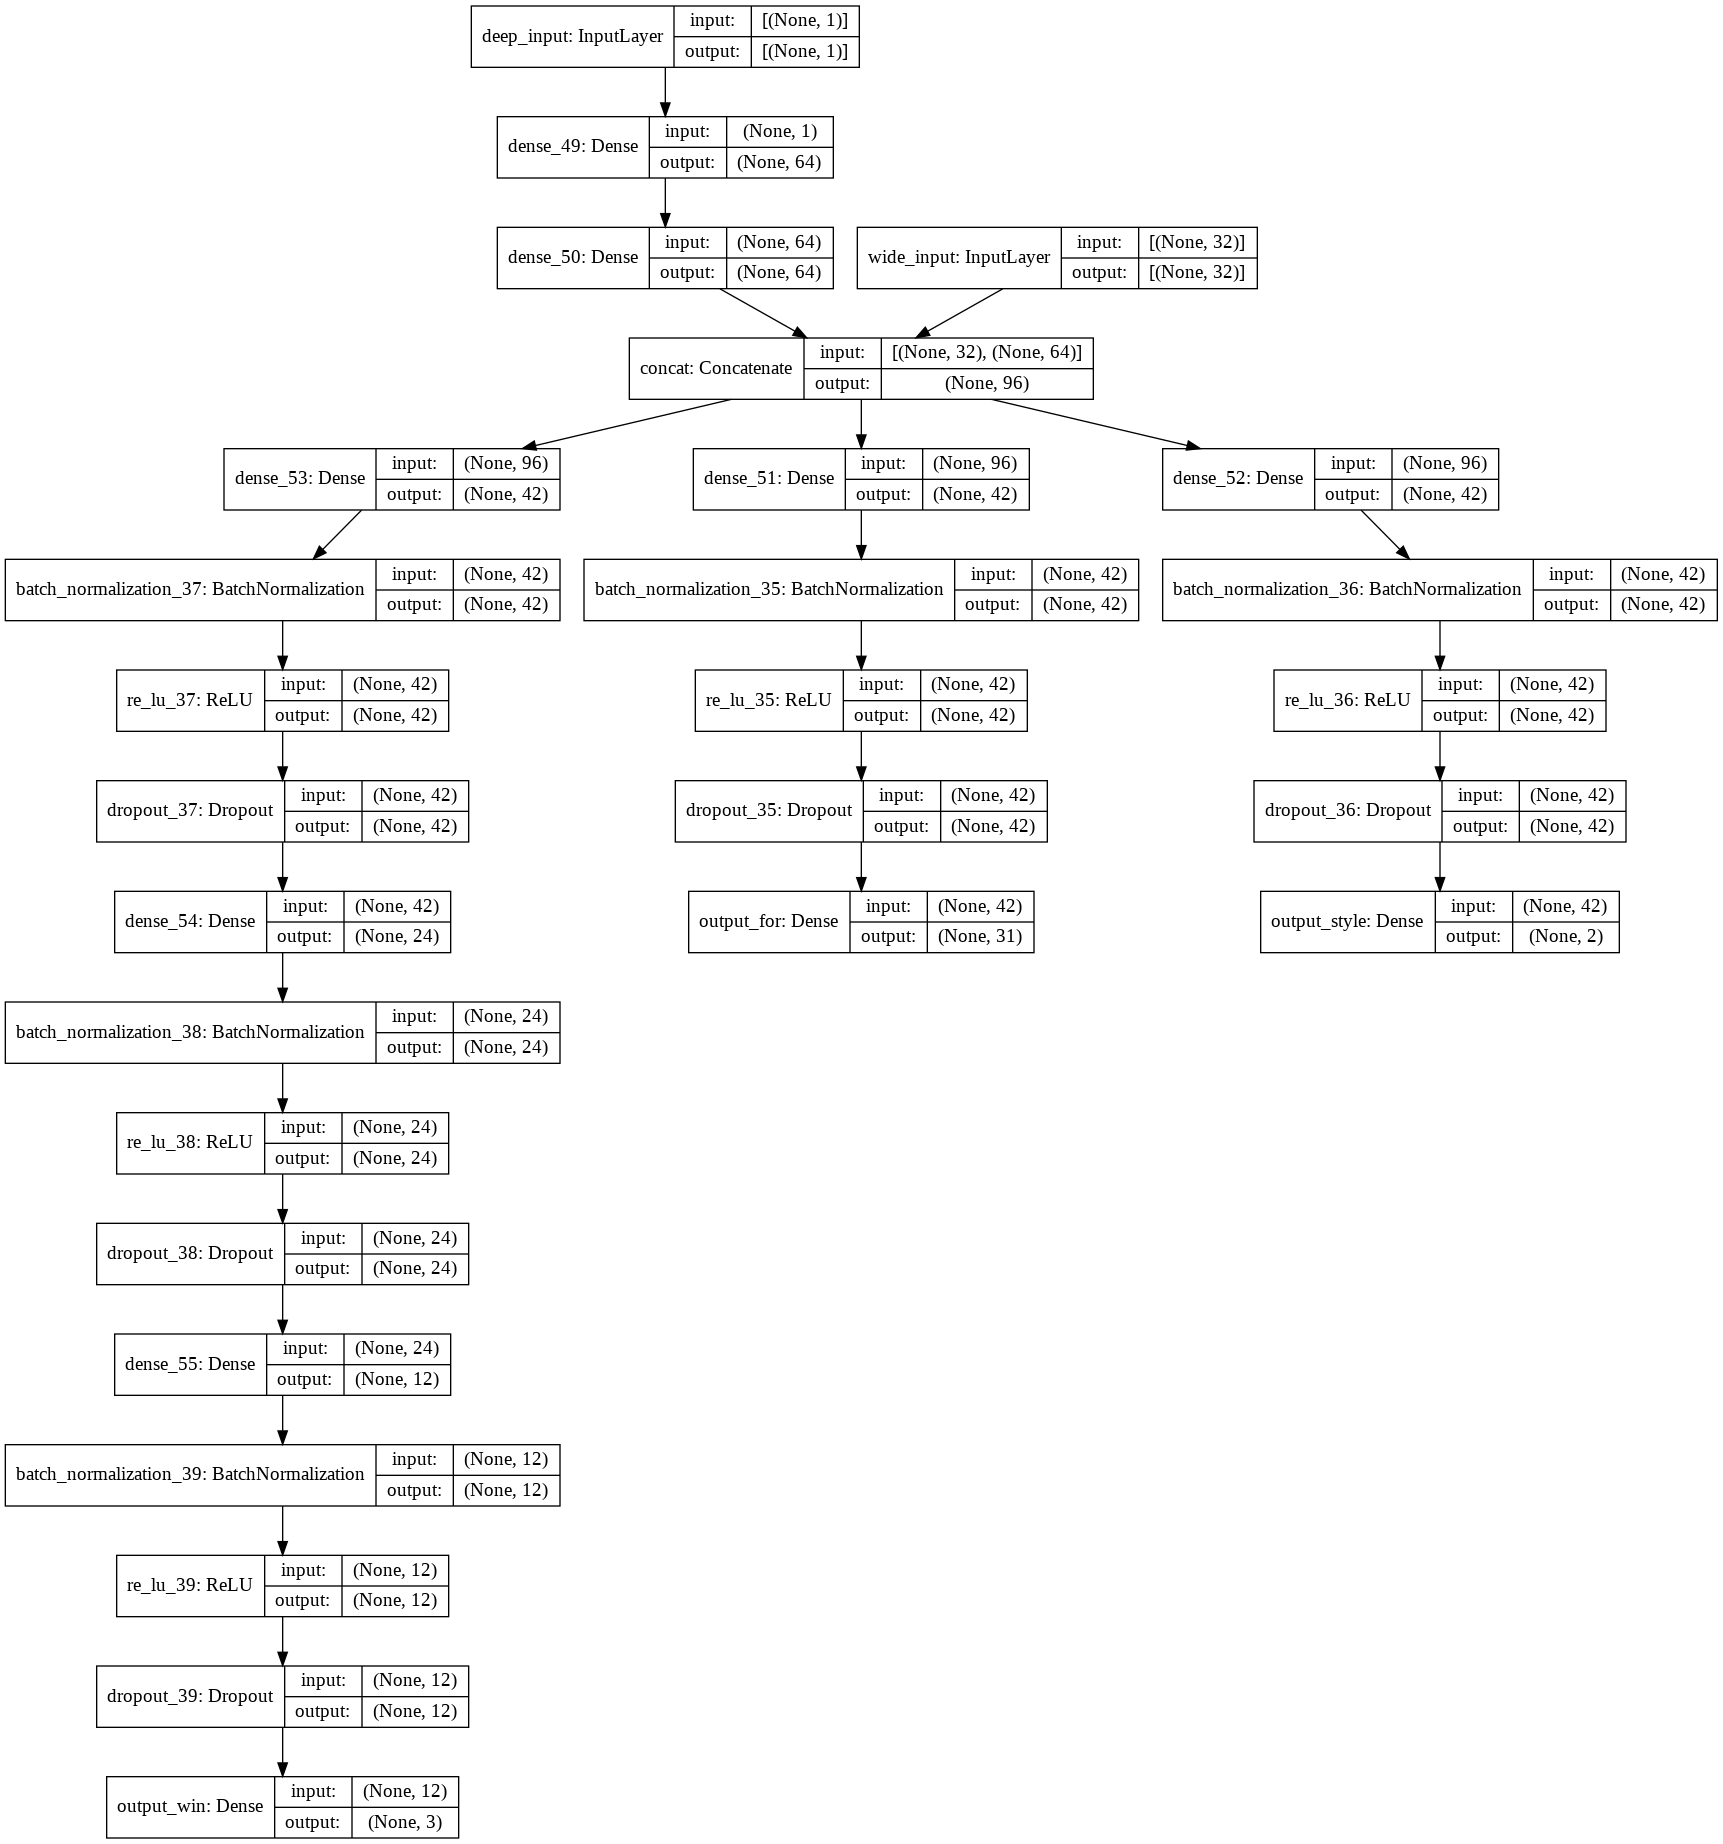

In [256]:
class MulticlassTruePositives(tf.keras.metrics.Metric):
    def __init__(self, name='multiclass_true_positives', **kwargs):
        super(MulticlassTruePositives, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.reshape(tf.argmax(y_pred, axis=1), shape=(-1, 1))
        values = tf.cast(y_true, 'int32') == tf.cast(y_pred, 'int32')
        values = tf.cast(values, 'float32')
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, 'float32')
            values = tf.multiply(values, sample_weight)
        self.true_positives.assign_add(tf.reduce_sum(values))

    def result(self):
        return self.true_positives

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.true_positives.assign(0.)



from keras import backend as K

def recall(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    recall = true_positives / (all_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
              loss= {'output_for': keras.losses.SparseCategoricalCrossentropy(), 
                      'output_win':keras.losses.SparseCategoricalCrossentropy(), 
                      'output_style':keras.losses.SparseCategoricalCrossentropy()},
              metrics =  {'output_for': [keras.metrics.SparseCategoricalAccuracy(), recall, precision],
                      'output_win':[keras.metrics.SparseCategoricalAccuracy(),recall, precision], 
                      'output_style':[keras.metrics.SparseCategoricalAccuracy(), recall, precision] }
              
              # {'output_for': [keras.losses.SparseCategoricalCrossentropy() ,keras.metrics.Precision(name='precision'),keras.metrics.Recall(name='recall')],
              #         'output_win':[keras.losses.SparseCategoricalCrossentropy(),keras.metrics.Precision(name='precision'),keras.metrics.Recall(name='recall')], 
              #         'output_style':[keras.losses.SparseCategoricalCrossentropy() ,keras.metrics.Precision(name='precision'),keras.metrics.Recall(name='recall')]}
)



early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience= 10, restore_best_weights=True)

keras.utils.plot_model(model, show_shapes=True)

In [257]:
history = model.fit(x=[x_train_A, x_train_B], y = [y_train_formation, y_train_style,y_train_win_rating], epochs=100, validation_split=0.2 , callbacks=[early_stop])

Epoch 1/100
10/10 [==============================] - 3s 76ms/step - loss: 4.6757 - output_for_loss: 2.8719 - output_style_loss: 0.4995 - output_win_loss: 1.1293 - output_for_sparse_categorical_accuracy: 0.2763 - output_for_recall: 0.0281 - output_for_precision: 0.4000 - output_style_sparse_categorical_accuracy: 0.7599 - output_style_recall: 1.0000 - output_style_precision: 1.0000 - output_win_sparse_categorical_accuracy: 0.4671 - output_win_recall: 0.5625 - output_win_precision: 1.0000 - val_loss: 4.6934 - val_output_for_loss: 2.2402 - val_output_style_loss: 1.2109 - val_output_win_loss: 1.0911 - val_output_for_sparse_categorical_accuracy: 0.4474 - val_output_for_recall: 0.0382 - val_output_for_precision: 0.6667 - val_output_style_sparse_categorical_accuracy: 0.6447 - val_output_style_recall: 1.0000 - val_output_style_precision: 1.0000 - val_output_win_sparse_categorical_accuracy: 0.4474 - val_output_win_recall: 0.2882 - val_output_win_precision: 1.0000
Epoch 2/100
10/10 [=============

In [258]:
model.evaluate(x=[x_test_A, x_test_B], y = [y_test_formation, y_test_style, y_test_win_rating])

# L2 정규화를 dense layer에 추가하니 살짝, 안정적으로 학습 진행됨! 

2/2 [==============================] - 0s 9ms/step - loss: 2.0107 - output_for_loss: 0.4821 - output_style_loss: 0.2007 - output_win_loss: 1.2048 - output_for_sparse_categorical_accuracy: 0.9211 - output_for_recall: 0.8698 - output_for_precision: 1.0000 - output_style_sparse_categorical_accuracy: 0.9211 - output_style_recall: 1.0000 - output_style_precision: 1.0000 - output_win_sparse_categorical_accuracy: 0.4474 - output_win_recall: 0.6094 - output_win_precision: 1.0000


[2.0107483863830566,
 0.48214539885520935,
 0.20065195858478546,
 1.2048038244247437,
 0.9210526347160339,
 0.8697916269302368,
 1.0,
 0.9210526347160339,
 1.0,
 1.0,
 0.44736841320991516,
 0.609375,
 1.0]

In [245]:
history.history.keys()

[dict_keys(['loss', 'output_for_loss', 'output_style_loss', 'output_win_loss', 'output_for_sparse_categorical_accuracy', 'output_for_recall', 'output_for_precision', 'output_style_sparse_categorical_accuracy', 'output_style_recall', 'output_style_precision', 'output_win_sparse_categorical_accuracy', 'output_win_recall', 'output_win_precision', 'val_loss', 'val_output_for_loss', 'val_output_style_loss', 'val_output_win_loss', 'val_output_for_sparse_categorical_accuracy', 'val_output_for_recall', 'val_output_for_precision', 'val_output_style_sparse_categorical_accuracy', 'val_output_style_recall', 'val_output_style_precision', 'val_output_win_sparse_categorical_accuracy', 'val_output_win_recall', 'val_output_win_precision'])]

In [279]:
# 1등 맨시티
# 10등 에버튼
# 20등 세필드 유나이티드

mc_data = test_data[test_data['oppense_team'] == 'Manchester City']

mc_pred_data = mc_data[["FW0", "FW0B", "FW1" ,'AMF0', 'AMF0B', 'AMF1', 'AMF1B',
       'Wing0', 'Wing0B', 'Wing1', 'Wing1B', 'CMF0', 'CMF0B', 'CMF0C', 'CMF1',
       'CMF1B', 'DMF0', 'DMF1', 'DMF1B', 'WB0', 'WB0B', 'WB1', 'WB1B', 'CB0',
       'CB0B', 'CB1', 'CB1B', 'GK0', 'GK1', 'reg_oppense_team', 'reg_oppense_level','reg_season','reg_ball_pos']].values.astype(np.float)



y_mc_formation = mc_data["label"].values.astype(np.int)
y_mc_win_rating = mc_data['win_index'].values.astype(np.int)
y_mc_style = mc_data['Style'].values.astype(np.int)

# 인풋 데이터의 형태에 따라 데이터를 나눈다.
x_mc_A, x_mc_B = mc_pred_data[:, :32], mc_pred_data[:, 32:]

mc_pred = model.predict(x = [x_mc_A, x_mc_B])

In [300]:
print(index_to_formation[mc_pred[0][0].argmax()])
print(mc_pred[1][0].argmax())
print(index_to_win[mc_pred[2][0].argmax()])
print(mc_pred[2][0].max() * 100)

4-2-0-1-3
1
Win
41.9843316078186


In [301]:
mc_pred[2]

array([[0.3976826 , 0.41984332, 0.1824741 ],
       [0.35786805, 0.51805574, 0.1240762 ]], dtype=float32)

In [302]:
index_to_win

{0: 'Lose', 1: 'Win', 2: 'Draw'}

In [293]:
mc_pred[0][0].argmax()

0

In [ ]:
formation_to_encoded = {x: i for i, x in enumerate(label_formation)}
index_to_formation = {i: x for i, x in enumerate(label_formation)}

season_to_encoded = {x: i for i, x in enumerate(season)}
index_to_season = {i: x for i, x in enumerate(season)} 

opp_level_to_encoded = {x: i for i, x in enumerate(opp_level)}
index_to_opp_level = {i: x for i, x in enumerate(opp_level)} 

oppense_team_to_encoded = {x: i for i, x in enumerate(oppense_team)}
index_to_oppense_team = {i: x for i, x in enumerate(oppense_team)} 

match_order_to_encoded = {x: i for i, x in enumerate(match_order)}
index_to_match_order = {i: x for i, x in enumerate(match_order)} 

win_to_encoded = {x: i for i, x in enumerate(win_cate)}
index_to_win = {i: x for i, x in enumerate(win_cate)} 

# baseline model - 


In [259]:
df = concat_df.sample(frac=1, random_state=42)

# 20-21 시즌 
test_data = df[df['Season'] == '2020-2021']

# 10-11 ~ 19-20 시즌 
train_data = df[df['Season'] != '2020-2021']


# feature의 값을 정규화 적용
x_train = train_data[["FW0", "FW0B", "FW1" ,'AMF0', 'AMF0B', 'AMF1', 'AMF1B',
       'Wing0', 'Wing0B', 'Wing1', 'Wing1B', 'CMF0', 'CMF0B', 'CMF0C', 'CMF1',
       'CMF1B', 'DMF0', 'DMF1', 'DMF1B', 'WB0', 'WB0B', 'WB1', 'WB1B', 'CB0',
       'CB0B', 'CB1', 'CB1B', 'GK0', 'GK1', 'reg_oppense_team', 'reg_oppense_level','reg_season','reg_ball_pos']].values.astype(np.float)



y_train_formation = train_data["label"].values.astype(np.int)
y_train_win_rating = train_data['win_index'].values.astype(np.int)
y_train_style = train_data['Style'].values.astype(np.int)


# feature의 값을 정규화 적용
x_test = test_data[["FW0", "FW0B", "FW1" ,'AMF0', 'AMF0B', 'AMF1', 'AMF1B',
       'Wing0', 'Wing0B', 'Wing1', 'Wing1B', 'CMF0', 'CMF0B', 'CMF0C', 'CMF1',
       'CMF1B', 'DMF0', 'DMF1', 'DMF1B', 'WB0', 'WB0B', 'WB1', 'WB1B', 'CB0',
       'CB0B', 'CB1', 'CB1B', 'GK0', 'GK1', 'reg_oppense_team', 'reg_oppense_level','reg_season','reg_ball_pos']].values.astype(np.float)



y_test_formation = test_data["label"].values.astype(np.int)
y_test_win_rating = test_data['win_index'].values.astype(np.int)
y_test_style = test_data['Style'].values.astype(np.int)


print(x_train.shape, x_test.shape)
print(y_train_formation.shape, y_train_win_rating.shape, y_train_style.shape)



(380, 33) (38, 33)
(380,) (380,) (380,)


In [265]:
learning_rate = 0.01
dropout_rate = 0.1

def baseline():
  inputs = layers.Input(shape = (x_train.shape[1]), name = 'baseline')
  #input_B = layers.Input(shape = (x_train_B.shape[1]), name = 'deep_input')

  # x = layers.Dense(64, activation='relu')(input_B)
  # x = layers.Dense(64, activation='relu')(x)

  # concat = layers.concatenate([input_A, x], name = 'concat')

  x_1 = layers.Dense(42)(inputs)
  #x_1 = layers.BatchNormalization()(x_1)
  x_1 = layers.ReLU()(x_1)
  #x_1 = layers.Dropout(dropout_rate)(x_1)
  output_for = layers.Dense(31, activation='softmax', name='output_for')(x_1)

  x_2 = layers.Dense(42)(inputs)
  # x_2 = layers.BatchNormalization()(x_2)
  x_2 = layers.ReLU()(x_2)
  # x_2 = layers.Dropout(dropout_rate)(x_2)
  output_style = layers.Dense(2, activation='softmax', name='output_style')(x_2)

  x_3 = layers.Dense(42 )(inputs)
  # x_3 = layers.BatchNormalization()(x_3)
  x_3 = layers.ReLU()(x_3)
  #x_3 = layers.Dropout(dropout_rate)(x_3)
  x_3 = layers.Dense(24)(x_3)
  #x_3 = layers.BatchNormalization()(x_3)
  x_3 = layers.ReLU()(x_3)
  #x_3 = layers.Dropout(dropout_rate)(x_3)
  x_3 = layers.Dense(12)(x_3)
  #x_3 = layers.BatchNormalization()(x_3)
  x_3 = layers.ReLU()(x_3)
  #x_3 = layers.Dropout(dropout_rate)(x_3)
  output_win = layers.Dense(3, activation='softmax', name='output_win')(x_3)



  model = keras.Model(inputs = inputs, outputs = [output_for, output_style, output_win],  name = 'baseline_multi_model')

  return model 


baseline = baseline()

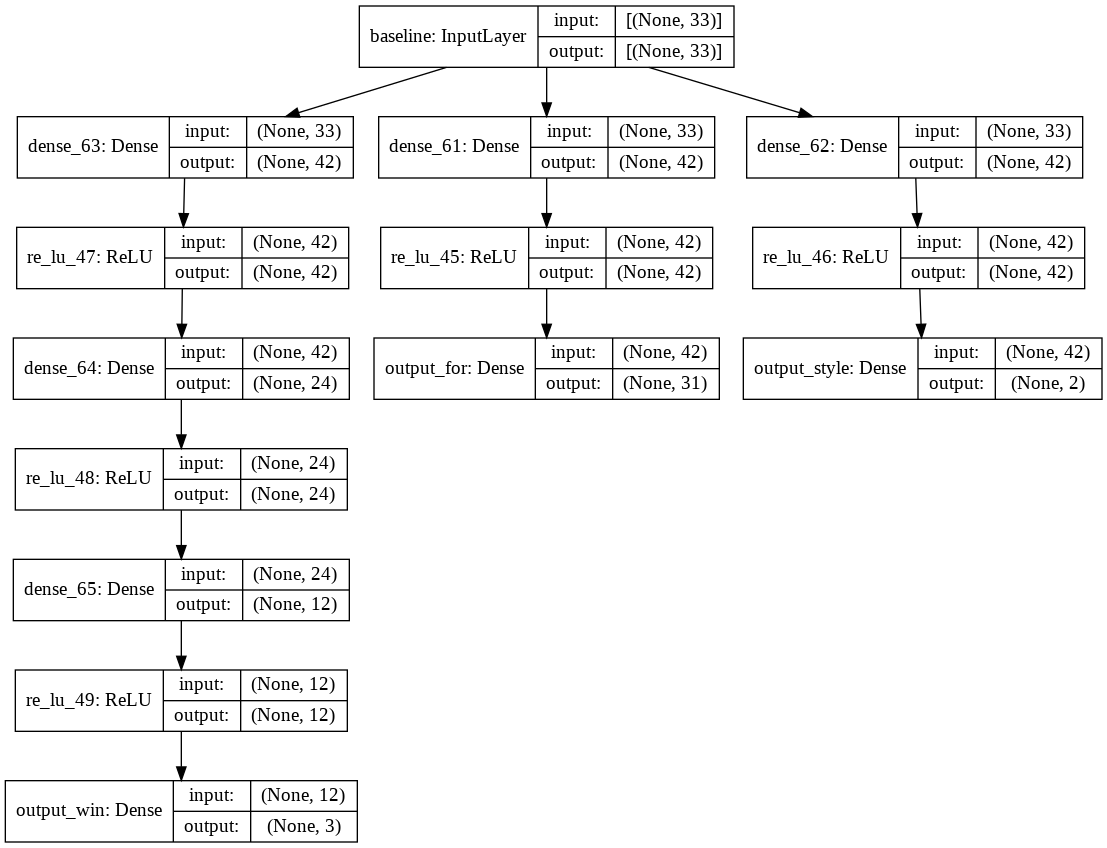

In [266]:
class MulticlassTruePositives(tf.keras.metrics.Metric):
    def __init__(self, name='multiclass_true_positives', **kwargs):
        super(MulticlassTruePositives, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.reshape(tf.argmax(y_pred, axis=1), shape=(-1, 1))
        values = tf.cast(y_true, 'int32') == tf.cast(y_pred, 'int32')
        values = tf.cast(values, 'float32')
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, 'float32')
            values = tf.multiply(values, sample_weight)
        self.true_positives.assign_add(tf.reduce_sum(values))

    def result(self):
        return self.true_positives

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.true_positives.assign(0.)



from keras import backend as K

def recall(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    recall = true_positives / (all_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



baseline.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
              loss= {'output_for': keras.losses.SparseCategoricalCrossentropy(), 
                      'output_win':keras.losses.SparseCategoricalCrossentropy(), 
                      'output_style':keras.losses.SparseCategoricalCrossentropy()},
              metrics =  {'output_for': [keras.metrics.SparseCategoricalAccuracy(), recall, precision],
                      'output_win':[keras.metrics.SparseCategoricalAccuracy(),recall, precision], 
                      'output_style':[keras.metrics.SparseCategoricalAccuracy(), recall, precision] }
              
              # {'output_for': [keras.losses.SparseCategoricalCrossentropy() ,keras.metrics.Precision(name='precision'),keras.metrics.Recall(name='recall')],
              #         'output_win':[keras.losses.SparseCategoricalCrossentropy(),keras.metrics.Precision(name='precision'),keras.metrics.Recall(name='recall')], 
              #         'output_style':[keras.losses.SparseCategoricalCrossentropy() ,keras.metrics.Precision(name='precision'),keras.metrics.Recall(name='recall')]}
)



early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience= 10, restore_best_weights=True)

keras.utils.plot_model(baseline, show_shapes=True)

In [268]:
history = baseline.fit(x= x_train, y = [y_train_formation, y_train_style,y_train_win_rating], epochs=100, validation_split=0.2 , callbacks=[early_stop])

Epoch 1/100
10/10 [==============================] - 2s 58ms/step - loss: 4.3422 - output_for_loss: 2.6561 - output_style_loss: 0.6656 - output_win_loss: 1.0204 - output_for_sparse_categorical_accuracy: 0.3717 - output_for_recall: 0.1750 - output_for_precision: 0.4000 - output_style_sparse_categorical_accuracy: 0.6086 - output_style_recall: 1.0000 - output_style_precision: 1.0000 - output_win_sparse_categorical_accuracy: 0.5526 - output_win_recall: 0.6156 - output_win_precision: 0.9000 - val_loss: 3.7262 - val_output_for_loss: 1.9721 - val_output_style_loss: 0.6883 - val_output_win_loss: 1.0658 - val_output_for_sparse_categorical_accuracy: 0.4474 - val_output_for_recall: 0.6806 - val_output_for_precision: 1.0000 - val_output_style_sparse_categorical_accuracy: 0.5395 - val_output_style_recall: 1.0000 - val_output_style_precision: 1.0000 - val_output_win_sparse_categorical_accuracy: 0.4605 - val_output_win_recall: 0.2778 - val_output_win_precision: 1.0000
Epoch 2/100
10/10 [=============

In [269]:
baseline.evaluate(x=x_test, y = [y_test_formation, y_test_style, y_test_win_rating])

# L2 정규화를 dense layer에 추가하니 살짝, 안정적으로 학습 진행됨! 

2/2 [==============================] - 0s 10ms/step - loss: 2.3019 - output_for_loss: 0.3935 - output_style_loss: 0.2379 - output_win_loss: 1.6705 - output_for_sparse_categorical_accuracy: 0.7895 - output_for_recall: 0.9844 - output_for_precision: 1.0000 - output_style_sparse_categorical_accuracy: 0.9474 - output_style_recall: 1.0000 - output_style_precision: 1.0000 - output_win_sparse_categorical_accuracy: 0.2368 - output_win_recall: 0.8542 - output_win_precision: 1.0000


[2.301939010620117,
 0.39352044463157654,
 0.23790670931339264,
 1.6705117225646973,
 0.7894737124443054,
 0.984375,
 1.0,
 0.9473684430122375,
 1.0,
 1.0,
 0.2368421107530594,
 0.8541666269302368,
 1.0]

In [270]:
history.history.keys()

dict_keys(['loss', 'output_for_loss', 'output_style_loss', 'output_win_loss', 'output_for_sparse_categorical_accuracy', 'output_for_recall', 'output_for_precision', 'output_style_sparse_categorical_accuracy', 'output_style_recall', 'output_style_precision', 'output_win_sparse_categorical_accuracy', 'output_win_recall', 'output_win_precision', 'val_loss', 'val_output_for_loss', 'val_output_style_loss', 'val_output_win_loss', 'val_output_for_sparse_categorical_accuracy', 'val_output_for_recall', 'val_output_for_precision', 'val_output_style_sparse_categorical_accuracy', 'val_output_style_recall', 'val_output_style_precision', 'val_output_win_sparse_categorical_accuracy', 'val_output_win_recall', 'val_output_win_precision'])